# Burnt area mapping using Sentinel-2 Near Real Time data  <img align="right" src="../Supplementary_data/dea_logo.jpg">
* __Compatability:__ Notebook currently only compatible with `DEA Sandbox` environment as near real time data is not available on the NCI
* **Products used:** 
[s2a_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_nrt_granule), 
[s2b_nrt_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_nrt_granule),
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule), 
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)

## Background

### Normalized Burn Ratio

The Normalized Burn Ratio (NBR) is an index that uses the differences in the way healthy green vegetation and burnt vegetation reflect light to find burnt area. 
It is calculated using the following Sentinel-2 bands: Near Infrared/Band 8 and Shortwave Infrared/Band 12. The equation is defined below: 

\begin{equation}
NBR = \frac{(NIR - SWIR)}{(NIR + SWIR)}
\end{equation}

NBR returns values between -1 and 1. 
**Healthy green vegetation will have a high NBR value while burnt vegetation will have a low value**. 
Areas of dry, brown vegetation or bare soil will also return lower NBR values than green vegetation. 

### Delta Normalized Burn Ratio

Change in Normalized Burn Ratio - also called Delta Normalized Burn Ratio (dNBR) - is calculated by subtracting the post-fire NBR value from the baseline NBR value as defined in this equation:

\begin{equation}
dNBR = NBR_{baseline} - NBR_{post fire}
\end{equation}

The dNBR value can be more useful than the NBR alone to determine what is burnt as it shows change from the baseline state. 
**A burnt area will have a positive dNBR value** while an unburnt area will have a negative dNBR value or a value close to zero.

dNBR can also be used to describe burn severity (although this notebook does not look at burn severity). 
A higher severity fire will burn more vegetation, resulting in a higher dNBR. More information on NBR, dNBR and using it to measure burn severity can be found [on the UN-SPIDER knowledge portal](http://un-spider.org/advisory-support/recommended-practices/recommended-practice-burn-severity/in-detail/normalized-burn-ratio).

### Defining Burnt From Unburnt Areas

[Rahman et al. 2018](https://doi.org/10.1109/IGARSS.2018.8518449) found a dNBR threshold value of +0.1 appropriate for differentiating burnt from unburnt areas when using Sentinel-2. 
However, some exploration with different threshold levels may be needed to get a good result in areas with different vegetation types. 

In the example presented in this notebook, which covers part of the Clyde Mountain fire in the area north of Batemans Bay, the fire occurred in heavily forested area, which returns a very strong dNBR result. 
Using +0.1 as a threshold here results in many false positives being picked up in the unburnt urban and forest areas where vegetation drying has occurred prior to the fire. 
A much more conservative threshold here of +0.3 produces a better result. 
Keep in mind the limitations of remote sensing and that in an ideal situation ground truth data collected in the location of interest would be used to assist in selecting a threshold.

Some care should also be taken when interpreting results as a number of possible false positives can return a positive dNBR result:

* A lot of smoke in the post burn image can interfere with the dNBR value
* Areas that have been cleared of vegetation by some other means (logging, harvesting, and landslides) towards the end of the baseline period may incorrectly show up as burnt
* Drying out of bright green vegetation such as grasses. 
If a fire event has been preceded by a rapid drying out of vegetation this can result in a low positive dNBR value in areas that have not burnt.


## Description

This notebook calculates the change in Normalized Burn Ratio between a baseline composite image of the pre-fire condition of a selected area and a post-fire event image, in order to find burnt area extent. 
**Specifically this notebook has been designed for mapping fire extent in recent fires, and so assumes that NRT products will need to be used. If the fire of interest is historical, users should select the definitive Sentinel-2 Analysis Ready Product instead.**
 
The user can change the location over which this notebook is run and specify a different date between which pre and post fire condition will be compared. 
The length of time over which the baseline composite image will be generated can be specified as 3, 6 or 12 months. 
The code in this notebook will automatically generate the composite image over the set length of time using both Sentinel-2 Near Real Time data and the definitive Sentinel 2 Analysis Ready Product.

The notebook contains the following steps:

1.  Select a location for the analysis
2.  Define fire event date and length of composite image
3.  Load all baseline data
4.  Generate Normalized Burn Ratio for baseline period
5.  Load post-fire data from Near Real Time data
6.  Generate Normalized Burn Ratio for post fire image
7.  Caculate Delta Normalized Burn Ratio
8.  Apply threshold to Delta Normalized Burn Ratio
9.  Calculate the area burnt
10. Export results as a GeoTIFF

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [22]:
import sys
import datacube
from datacube.helpers import write_geotiff
from datetime import datetime
from datetime import timedelta
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import math

sys.path.append("../Scripts")
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_plotting import display_map
from dea_bandindices import calculate_indices

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Burnt_area_mapping")

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [48]:
# Set the central latitude and longitude
central_lat = -34.7 #-27.1 #-31.6
central_lon = 138.7 #153.1 #135.8

# Set the buffer to load around the central coordinates
buffer = 0.5

# Compute the bounding box for the study area
study_area_lat = (central_lat - buffer, central_lat + buffer)
study_area_lon = (central_lon - buffer, central_lon + buffer)

display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: h

## Load all baseline data

In [49]:
ds = dc.load(product="ls8_nbart_geomedian_annual",
             x=study_area_lon,
             y=study_area_lat,
             time=('2018'))

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 3881, y: 4639)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01
  * y            (y) float64 -3.747e+06 -3.747e+06 ... -3.863e+06 -3.863e+06
  * x            (x) float64 5.631e+05 5.631e+05 ... 6.601e+05 6.601e+05
    spatial_ref  int32 0
Data variables:
    blue         (time, y, x) int16 659 573 555 552 544 ... 739 739 749 764 766
    green        (time, y, x) int16 873 759 733 723 709 ... 951 957 964 967 969
    red          (time, y, x) int16 732 632 616 609 597 ... 1214 1215 1212 1223
    nir          (time, y, x) int16 283 258 260 259 259 ... 2224 2247 2242 2217
    swir1        (time, y, x) int16 126 107 97 98 105 ... 3249 3292 3285 3291
    swir2        (time, y, x) int16 97 83 77 77 82 ... 2384 2365 2369 2351 2353
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref


Plot the baseline NBR data side-by-side with an RGB plot of the study area:

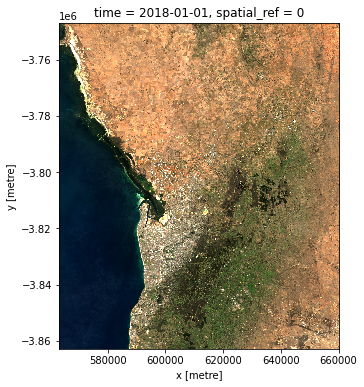

In [50]:
rgb(ds,bands=['red','green','blue'])

In [51]:
image = ds.isel(time=0)

### Calculate indices

SI(Salinity_Index) = SQRT (ETM3 * ETM4) (3)
NDSI = (ETM3 – ETM4) / (ETM3 + ETM4) (4)
IS_Modified = [SQRT (ETM3)² +(ETM4)²] (5)
VSSI = 2 * ETM2 – 5 * (ETM3 + ETM4) (6)
Brightness_Index = SQRT [(ETM3)² + (ETM4)² ] (7)
Salinity Ratio = (ETM3 – ETM4) / (ETM2 + ETM4) (8)
NDBI = (ETM6 – ETM4) / (ETM6 + ETM4) (9)
NDVI = (ETM4 – ETM4) / (ETM3 + ETM4) (10)

- Normlized Difference Salinity Index landsat bands (SWIR_1−SWIR_2)/(SWIR_1+SWIR_2) (https://www.indexdatabase.de/db/i-single.php?id=57)

/env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


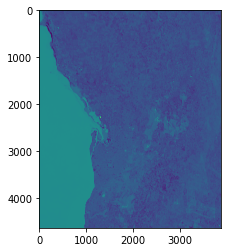

In [52]:
ds['ndsi'] = (ds['red']-ds['nir'])/(ds['red']+ds['nir'])
ds['vssi'] = 2*ds['green']-5*(ds['red']+ds['nir'])
ds['bi'] = np.sqrt((ds['red']^2)+(ds['nir']^2))
ds['si'] = np.sqrt(ds['nir']+ds['red'])

plt.imshow(ds['vssi'].isel(time=0))


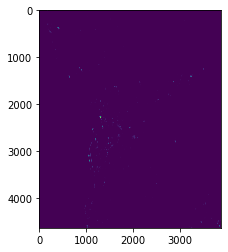

In [53]:
ndsi = ds['vssi']>0
plt.imshow(ndsi.isel(time=0))

## Export results to GeoTIFF

The baseline reference image and the post fire image will both be saved as a multiband GeoTIFF with the following bands in the following order: Blue, Green, Red, NIR, SWIR. 

The thresholded burnt area image will be saved as a single band image, where a value of 1 = burnt and a value of 0 = not burnt.

In [20]:
# Define an area name to be used in saved file names
area_name = 'Salty'

# Write baseline reference image to multi-band GeoTIFF
write_geotiff(f'{area_name}_baseline_image.tif', image)

/env/lib/python3.6/site-packages/datacube/helpers.py:34: DeprecationWarning: Function datacube.helpers.write_geotiff is deprecated,
please use datacube.utils.cog.write_cog instead
  category=DeprecationWarning)


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** April 2020

**Compatible datacube version:** 

In [21]:
print(datacube.__version__)

1.8.0b7.dev35+g5023dada


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)